# Machine Learning Pipeline - Feature Engineering

In the following notebooks, we will go through the implementation of each of the steps in the Machine Learning Pipeline.

We will discuss:

1. Data Analysis
2. **Feature Engineering**
3. Feature Selection
4. Model Training
5. Model Evaluation

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to rank our non-parametric target
from scipy.stats import rankdata

# to visualise all the columns in the dataframe
pd.pandas.set_option('display.max_columns',None)

In [2]:
# load dataset
data = pd.read_csv('student-mat.csv',sep=';')

In [3]:
# rows and columns of the data
print(f'Number of rows: {data.shape[0]}')
print(f'Number of columns: {data.shape[1]}')

Number of rows: 395
Number of columns: 33


In [4]:
# drop G1 and G2
# they are too predictive of the target
data = data.drop(['G1','G2'],axis=1)

# visualise the dataset
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,10


# Separate dataset into train and test

It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

**Separating the data into train and test involves randomness, therefore, we need to set the seed.**

In [5]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('G3',axis=1), # predictive variables
    data['G3'], # target
    test_size=0.3, # portion of dataset to allocate to test set
    random_state=0) # we are setting the seed here

In [6]:
X_train.shape, X_test.shape

((276, 30), (119, 30))

# Feature Engineering

## Target

We indicated our target seems normally distributed so we will not be adjusting the distribution or making any changes.

## Missing Values

The dataset contains no missing values.

## Numerical Variable Transformation

### Continuous Variables
Outside the discrete variable, we have only one true continuous variable - 'absences'.

In [7]:
X_train['absences'].head()

22     2
241    2
122    2
176    2
162    0
Name: absences, dtype: int64

Let's visualise the distribution.

Text(0.5, 0, 'absences')

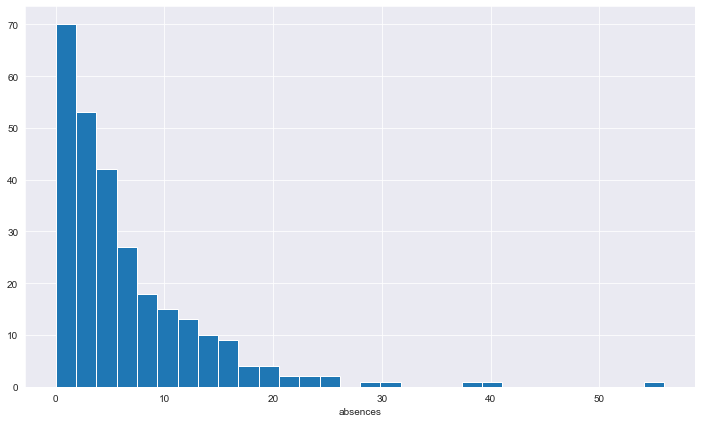

In [8]:
plt.figure(figsize=(12,7))
X_train['absences'].hist(bins=30)
plt.xlabel('absences')

We can't address the distribution without mentioning its outliers. We also can't talk about the outliers without mentioning our "inliers", i.e. the inter-quartile range. As such, we have to determine what would be an acceptable range of absences. This range would have to be sourced from domain knowledge (i.e. class teacher, principal, school administrator, etc..) 

In the absence of verifiable domain knowledge, we can speculate. The highest possible number of absences is 93 per the attributes description. We can assume those are the total number of school days in the academic period for the course. The lowest number of absences would be 0.

Since the highest incidences of absences occur around 0, let's assume absences between 0 and 10 are pretty normal. We can also assume absences between 10 and 20 are rare. The absences between 20 and 93 are just a few instances and can be termed unlikely.

NOTE: It would be hard to find a normal distribution for a variable like absences because most students will be present for much of the school year and the least possible absences is 0 which indicates attendance on all school days. This prevents a two-tailed distribution for the variable.

Let's observe the relationship between absences and grade performance for the training data:

Text(0.5, 0, 'absences')

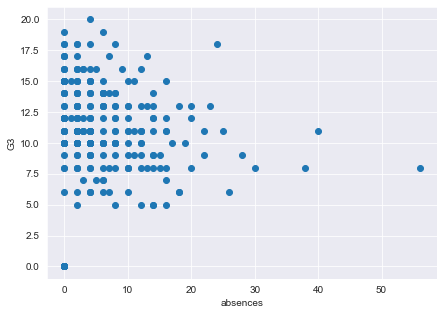

In [9]:
plt.figure(figsize=(7,5))
plt.scatter(x='absences',y='G3',data=pd.concat([X_train,y_train],axis=1))
plt.ylabel('G3')
plt.xlabel('absences')

In the previous notebook, we observed that the most extremely absent students had final scores clustered around our cut-off passing grade. We also notice the same trend with the training data.

In the absence of domain knowledge, we can now hypothesize that extreme absences are an unlikely occurence but when they do happen, it must be for a cogent reason because most absent students would perform well if they were around more often. Ultimately, per the training data, absences are not a reliable predictor of performamce.

It bears mentioning anyways that this distribution would have to be monitired for possible shifts or changes in the future that might require model calibration or re-training.

## Categorical Variables

### Removing Rare Labels

Before removing rare labels, we would ideally re-map string variables that have values with an assigned order. Luckily for us, these variables have already been mapped in the data.

For the remaining categorical variables, we will group categories that are present in less than 1% of the observations and replace them with the string "Rare".

In [10]:
# capture all the categorical variables

cat_vars = ['school',
            'sex',
            'address',
            'famsize',
            'Pstatus',
            'Mjob',
            'Fjob',
            'reason',
            'guardian',
            'schoolsup',
            'famsup',
            'paid',
            'activities',
            'nursery',
            'higher',
            'internet',
            'romantic']

In [11]:
def find_frequent_labels(df, var, rare_perc):
    
    # this function finds the labels that are shared by more than
    # a certain % of the obs in the dataset
    
    df = df.copy()
    
    tmp = df.groupby(var)[var].count() / len(df)
    
    return tmp[tmp > rare_perc].index

In [12]:
for var in cat_vars:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    
    print(var, frequent_ls)
    print()
    
    # replace rare categories with the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

school Index(['GP', 'MS'], dtype='object', name='school')

sex Index(['F', 'M'], dtype='object', name='sex')

address Index(['R', 'U'], dtype='object', name='address')

famsize Index(['GT3', 'LE3'], dtype='object', name='famsize')

Pstatus Index(['A', 'T'], dtype='object', name='Pstatus')

Mjob Index(['at_home', 'health', 'other', 'services', 'teacher'], dtype='object', name='Mjob')

Fjob Index(['at_home', 'health', 'other', 'services', 'teacher'], dtype='object', name='Fjob')

reason Index(['course', 'home', 'other', 'reputation'], dtype='object', name='reason')

guardian Index(['father', 'mother', 'other'], dtype='object', name='guardian')

schoolsup Index(['no', 'yes'], dtype='object', name='schoolsup')

famsup Index(['no', 'yes'], dtype='object', name='famsup')

paid Index(['no', 'yes'], dtype='object', name='paid')

activities Index(['no', 'yes'], dtype='object', name='activities')

nursery Index(['no', 'yes'], dtype='object', name='nursery')

higher Index(['no', 'yes'], dtype='ob

Let's see if we picked up any rare values:

In [13]:
for var in cat_vars:
    print(f'train_{var}: {X_train[var].unique()}')
    print(f'test_{var}: {X_test[var].unique()}')
    print()

train_school: ['GP' 'MS']
test_school: ['GP' 'MS']

train_sex: ['M' 'F']
test_sex: ['F' 'M']

train_address: ['U' 'R']
test_address: ['U' 'R']

train_famsize: ['LE3' 'GT3']
test_famsize: ['GT3' 'LE3']

train_Pstatus: ['T' 'A']
test_Pstatus: ['T' 'A']

train_Mjob: ['teacher' 'other' 'services' 'health' 'at_home']
test_Mjob: ['teacher' 'at_home' 'other' 'services' 'health']

train_Fjob: ['other' 'health' 'services' 'teacher' 'at_home']
test_Fjob: ['teacher' 'services' 'other' 'at_home' 'health']

train_reason: ['course' 'reputation' 'home' 'other']
test_reason: ['course' 'reputation' 'other' 'home']

train_guardian: ['mother' 'father' 'other']
test_guardian: ['mother' 'father' 'other']

train_schoolsup: ['no' 'yes']
test_schoolsup: ['no' 'yes']

train_famsup: ['no' 'yes']
test_famsup: ['yes' 'no']

train_paid: ['no' 'yes']
test_paid: ['yes' 'no']

train_activities: ['yes' 'no']
test_activities: ['no' 'yes']

train_nursery: ['yes' 'no']
test_nursery: ['no' 'yes']

train_higher: ['yes' 'no

The operation found no rare values in our categorical variables just like we did in the previous notebook.

### Encoding of categorical variables

Next, we need to transform the strings of the categorical variables into numbers. Note that we have two kinds of categorical variables - binary and non-binary.

We will apply one-hot encoding on our binary features. For our non-binary features, we will transform the strings into numbers that capture the monotonic relationship between the label/category and the target.

#### Binary variables

In [14]:
binary_vars = [var for var in cat_vars if X_train[var].nunique() == 2]
binary_vars

['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [15]:
def category_encoder(X,variables):
        
        # loop over each feature in the list
        for feature in variables:
            
            dummies = pd.get_dummies(X[feature],drop_first=True) # grab the dummies
            for column in dummies.columns: # loop over the columns in the dummies dataframe
                dummies = dummies.rename(columns={column:feature + '_' + column}) # affix the feature name to the column name to make it easily identifiable
            X = pd.concat([X,dummies],axis=1) # concat the dummy to the original dataframe
            X = X.drop(feature,axis=1) # drop the string column
        return X # return the dataframe

In [16]:
X_train = category_encoder(X_train,binary_vars)
X_test = category_encoder(X_test,binary_vars)

In [17]:
X_train.head()

,age,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
22,16,4,2,teacher,other,course,mother,1,2,0,4,5,1,1,3,5,2,0,1,1,1,1,0,0,0,1,1,1,1,0
241,17,4,4,teacher,other,course,mother,2,2,0,3,3,3,2,3,4,2,0,1,0,1,0,0,1,1,0,1,1,1,0
122,16,2,4,other,health,course,father,2,2,0,4,2,2,1,2,5,2,0,0,1,1,1,0,1,1,1,1,1,1,1
176,16,2,2,services,other,reputation,mother,2,2,0,3,4,4,1,4,5,2,0,0,1,0,1,0,0,1,1,0,1,1,0
162,16,1,2,other,other,course,mother,2,1,1,4,4,4,2,4,5,0,0,1,1,1,1,0,0,0,1,1,1,0,0


#### Non-binary variables

Next, we will transform the strings of the non-binary categorical variables into numbers that we capture the monotonic relationship between the label and the target.

In [18]:
non_binary_vars = [var for var in cat_vars if var not in binary_vars]
non_binary_vars

['Mjob', 'Fjob', 'reason', 'guardian']

In [19]:
tmp = pd.concat([X_train, y_train], axis=1)
#tmp = tmp.sort_values(by=['G3'])
ranked = rankdata(tmp['G3'])
tmp['rank'] = ranked

In [20]:
tmp.head()

,age,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,G3,rank
22,16,4,2,teacher,other,course,mother,1,2,0,4,5,1,1,3,5,2,0,1,1,1,1,0,0,0,1,1,1,1,0,16,254.5
241,17,4,4,teacher,other,course,mother,2,2,0,3,3,3,2,3,4,2,0,1,0,1,0,0,1,1,0,1,1,1,0,12,172.0
122,16,2,4,other,health,course,father,2,2,0,4,2,2,1,2,5,2,0,0,1,1,1,0,1,1,1,1,1,1,1,13,196.0
176,16,2,2,services,other,reputation,mother,2,2,0,3,4,4,1,4,5,2,0,0,1,0,1,0,0,1,1,0,1,1,0,11,140.0
162,16,1,2,other,other,course,mother,2,1,1,4,4,4,2,4,5,0,0,1,1,1,1,0,0,0,1,1,1,0,0,0,10.0


In [21]:
for var in non_binary_vars:
    ordered_labels = tmp.groupby([var])['rank'].sum().sort_values().index
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 1)}
    
    print(f'{var}: {ordinal_label}')
    
    X_train[var] = X_train[var].map(ordinal_label)
    X_test[var] = X_test[var].map(ordinal_label)

Mjob: {'health': 1, 'at_home': 2, 'teacher': 3, 'services': 4, 'other': 5}
Fjob: {'at_home': 1, 'health': 2, 'teacher': 3, 'services': 4, 'other': 5}
reason: {'other': 1, 'home': 2, 'reputation': 3, 'course': 4}
guardian: {'other': 1, 'father': 2, 'mother': 3}


In [22]:
X_train[non_binary_vars].head()

,Mjob,Fjob,reason,guardian
22,3,5,4,3
241,3,5,4,3
122,5,2,4,2
176,4,5,3,3
162,5,5,4,3


To illustrate the monotonic relationship between the variables and the target:

In [23]:
X_train['rank'] = tmp['rank']

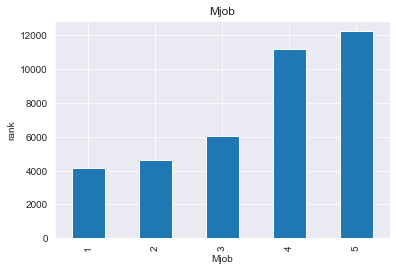

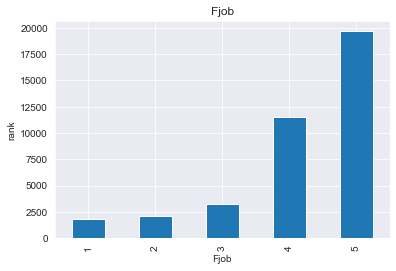

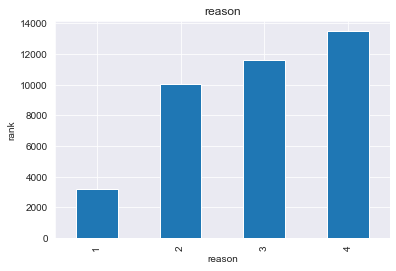

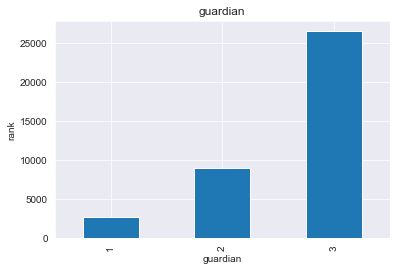

In [24]:
def analyse_vars(X_train, var):
    
    X_train.groupby(var)['rank'].sum().plot.bar()
    plt.title(var)
    plt.ylabel('rank')
    plt.show()

for var in non_binary_vars:
    analyse_vars(X_train,var)

The monotonic relationship is particularly clear for the Fjob and Mjob variables. The higher the integer represeting their jobs, the higher the grades of their kids on average.

In [25]:
X_train.head()

,age,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,rank
22,16,4,2,3,5,4,3,1,2,0,4,5,1,1,3,5,2,0,1,1,1,1,0,0,0,1,1,1,1,0,254.5
241,17,4,4,3,5,4,3,2,2,0,3,3,3,2,3,4,2,0,1,0,1,0,0,1,1,0,1,1,1,0,172.0
122,16,2,4,5,2,4,2,2,2,0,4,2,2,1,2,5,2,0,0,1,1,1,0,1,1,1,1,1,1,1,196.0
176,16,2,2,4,5,3,3,2,2,0,3,4,4,1,4,5,2,0,0,1,0,1,0,0,1,1,0,1,1,0,140.0
162,16,1,2,5,5,4,3,2,1,1,4,4,4,2,4,5,0,0,1,1,1,1,0,0,0,1,1,1,0,0,10.0


In [26]:
# let's now save the train and test sets for the next notebook!

X_train.to_csv('xtrain_unscaled.csv', index=False)
X_test.to_csv('xtest_unscaled.csv', index=False)

y_train.to_csv('ytrain.csv', index=False)
y_test.to_csv('ytest.csv', index=False)